In [48]:
import glob
import random
import matplotlib.pyplot as plt


def get_random_image(dir, condition):
    type_of_image = {"n": "NORMAL", "p": "PNEUMONIA"}

    placeholder = type_of_image.get(condition)
    if placeholder is None:
        raise Exception("Unknown condition")
            
    folder = f"./data/chest_xray/chest_xray/{dir}/{placeholder}/*.jpeg"  
    image_paths = glob.glob(folder)
    max_length = len(image_paths)
    random_number = random.randint(0, max_length)
    for index, item in enumerate(image_paths, start=1):
        if index == random_number:
            print(index,item)
            image = plt.imread(item)
            ready_image=plt.imshow(image)
            plt.show()
            return ready_image


985 ./data/chest_xray/chest_xray/train/PNEUMONIA/person470_bacteria_1996.jpeg


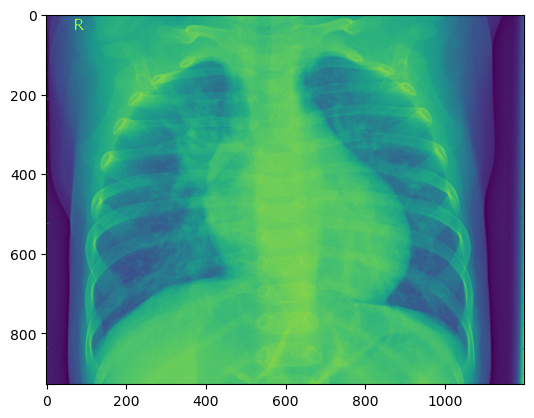

In [49]:
get_random_image("train","p")

In [50]:
from PIL import Image

def format_image_filenames(dir):
    folder = f"./data/chest_xray/{dir}/*/*.jpeg"
    
    counter_pneumonia = 0
    counter_normal = 0
    
    image_paths = glob.glob(folder)
    
    for img in image_paths:
        if "person" in img:
            full_size_image = Image.open(img)
            image = full_size_image.resize((224,224))
            plt.imsave(fname = f"./data/chest_xray/{dir}/train_pneumonia"+str(counter_pneumonia)+'.jpeg', arr=image,format = "jpeg", cmap = 'gray')
            counter_pneumonia+=1
        else:
            full_size_image = Image.open(img)
            image=full_size_image.resize((224,224))
            plt.imsave(fname=f"./data/chest_xray/{dir}/train_normal"+str(counter_normal)+'.jpeg', arr=image,format="jpeg", cmap='gray')
            counter_normal+=1

In [51]:
image_filenames = ['train','test','val']

for filename in image_filenames:    
    format_image_filenames(filename)